**Download the data from source**

In [1]:
!wget https://s3.us-east-2.amazonaws.com/audiosamplesyk/train.csv


Redirecting output to ‘wget-log’.


In [2]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
!wget  https://s3.us-east-2.amazonaws.com/audiosamplesyk/test.csv


Redirecting output to ‘wget-log.1’.


In [4]:
!wget https://s3.amazonaws.com/audiosampleyug/glove.6B.100d.txt 


Redirecting output to ‘wget-log.2’.


**Load required libraries**

In [5]:
import os
import sys
import numpy as np
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model

Using TensorFlow backend.


**Read the data**

In [0]:
df_train = pd.read_csv("train.csv")

df_test = pd.read_csv("test.csv")

**Print head and tail of the data**

In [7]:
df_train.head()

,ID,categories,converse
0,2,ASK_A_DOCTOR,mom wants to know if the drugname needs some d...
1,3,ASK_A_DOCTOR,patients to discuss drugname she says she has ...
2,5,MISCELLANEOUS,letter of patient establishment request name s...
3,6,APPOINTMENTS,appointment question name mom appointments pat...
4,8,MISCELLANEOUS,please refax neurocog order to new wake medici...


In [8]:
df_train.tail()

,ID,categories,converse
45820,57276,PRESCRIPTION,out of medicines rxs name mom prescription ref...
45821,57277,ASK_A_DOCTOR,patients mom to report a migraine name mom tri...
45822,57278,MISCELLANEOUS,dental clearance rna follow dental office want...
45823,57279,MISCELLANEOUS,catheter documentation from other clinic name ...
45824,57280,MISCELLANEOUS,status of fmla form awaiting md completion nam...


In [9]:
df_test.head()

,ID,converse
0,1,patients aware that he needs rov for refill na...
1,4,fyi nortryptline medication patient prescripti...
2,7,dizzy double vision past mins after ct other h...
3,13,please go ahead and order mandibular repositio...
4,18,last office note faxed to nceent from other cl...


**Check structure and summary of the data**

In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45825 entries, 0 to 45824
Data columns (total 3 columns):
ID            45825 non-null int64
categories    45825 non-null object
converse      45796 non-null object
dtypes: int64(1), object(2)
memory usage: 1.0+ MB


In [11]:
df_train.describe()

,ID
count,45825.000000
mean,28645.024441
std,16545.373029
min,2.000000
25%,14296.000000
50%,28668.000000
75%,42965.000000
max,57280.000000


In [12]:
print('Shape of dataset ',df_train.shape)
print(df_train.columns)
print('No. of unique classes',len(set(df_train['categories'])))

Shape of dataset  (45825, 3)
Index(['ID', 'categories', 'converse'], dtype='object')
No. of unique classes 6


In [13]:
df_train.categories.unique()

array(['ASK_A_DOCTOR', 'MISCELLANEOUS', 'APPOINTMENTS', 'LAB',
       'PRESCRIPTION', 'JUNK'], dtype=object)

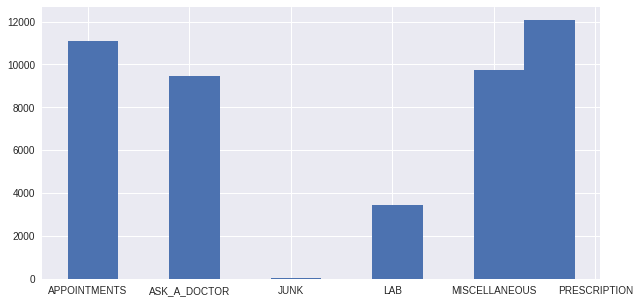

In [103]:
import seaborn as sns
sns.set()
fig = plt.figure()
plt.figure(figsize=(10,5))
plt.hist(df_train.categories)
plt.xticks(np.arange(0.2, 6, step=1.))
#plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
#plt.xlabel('Epochs ',fontsize=16)
#plt.ylabel('Loss',fontsize=16)
#plt.title('Loss Curves :LSTM',fontsize=16)
#fig5.savefig('loss_lstm.png')
plt.show()
sns.set_context("paper")

**Check null values**

In [14]:
df_train.isnull().sum()

ID             0
categories     0
converse      29
dtype: int64

In [15]:
df_test.isnull().sum()

ID          0
converse    7
dtype: int64

**Observe the rows having null values**

In [16]:
tr_nan_idx = df_train[pd.isnull(df_train['converse'])].index.tolist()

print(df_train.loc[tr_nan_idx])

          ID     categories converse
551      682  MISCELLANEOUS      NaN
2207    2749  MISCELLANEOUS      NaN
5328    6688           JUNK      NaN
9688   12086           JUNK      NaN
10195  12694   APPOINTMENTS      NaN
12782  15924           JUNK      NaN
12831  15996  MISCELLANEOUS      NaN
14144  17639           JUNK      NaN
14207  17721           JUNK      NaN
14767  18432           JUNK      NaN
15888  19830  MISCELLANEOUS      NaN
15905  19852  MISCELLANEOUS      NaN
19580  24492           JUNK      NaN
20678  25887           JUNK      NaN
20760  25991  MISCELLANEOUS      NaN
21474  26892  MISCELLANEOUS      NaN
22960  28731           JUNK      NaN
23029  28817           JUNK      NaN
24152  30198  MISCELLANEOUS      NaN
24407  30512  MISCELLANEOUS      NaN
27780  34727  MISCELLANEOUS      NaN
28106  35140  MISCELLANEOUS      NaN
29548  36966  MISCELLANEOUS      NaN
30219  37810  MISCELLANEOUS      NaN
30635  38328  MISCELLANEOUS      NaN
35446  44341  MISCELLANEOUS      NaN
3

In [17]:
ts_nan_idx = df_test[pd.isnull(df_test['converse'])].index.tolist()

print(df_test.loc[ts_nan_idx])

         ID converse
2811  14194      NaN
3603  18173      NaN
4447  22293      NaN
6261  31275      NaN
6737  33762      NaN
9539  47537      NaN
9702  48370      NaN


**Replace NaN with white space**

In [0]:
df_train.loc[tr_nan_idx, 'converse'] = ' '
df_test.loc[ts_nan_idx, 'converse'] = ' '

In [19]:
print(df_test.loc[ts_nan_idx])

         ID converse
2811  14194         
3603  18173         
4447  22293         
6261  31275         
6737  33762         
9539  47537         
9702  48370         


**Now again check null values**

In [20]:
df_train.isnull().sum()

ID            0
categories    0
converse      0
dtype: int64

In [21]:
df_test.isnull().sum()

ID          0
converse    0
dtype: int64

In [0]:
#dictionary mapping label name to numeric id
sort=sorted(set(df_train['categories']))
labels_index = dict((text, number) for text, number in enumerate(sort))


In [23]:
labels_index

{0: 'APPOINTMENTS',
 1: 'ASK_A_DOCTOR',
 2: 'JUNK',
 3: 'LAB',
 4: 'MISCELLANEOUS',
 5: 'PRESCRIPTION'}

In [0]:
texts = df_train.converse
labels = df_train.categories
ts_texts = df_test.converse

**Text Preprocessing using keras**

In [0]:
MAX_SEQUENCE_LENGTH = 1000
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2
nb_epochs = 10

In [26]:
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
ts_sequences = tokenizer.texts_to_sequences(ts_texts)

word_index = tokenizer.word_index
print('Number of Unique Tokens',len(word_index))

Number of Unique Tokens 34769


In [0]:
# converts the character array to numeric array. Assigns levels to unique labels.
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()                 
le.fit(labels)
train_labels = le.transform(labels)

In [28]:
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
ts_data = pad_sequences(ts_sequences, maxlen=MAX_SEQUENCE_LENGTH)
labels = to_categorical(np.asarray(train_labels))
print('Shape of Data Tensor:', data.shape)
print('Shape of Label Tensor:', labels.shape)

Shape of Data Tensor: (45825, 1000)
Shape of Label Tensor: (45825, 6)


**Train and validation split**

In [0]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

In [30]:
indices

array([17789, 24913, 26511, ..., 25959, 34190, 26556])

**Build index mapping words in the embeddings set to their embedding vector**

In [31]:
embeddings_index = {}
f = open('glove.6B.100d.txt',encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Total %s word vectors in Glove 6B 100d.' % len(embeddings_index))

Total 400000 word vectors in Glove 6B 100d.


**Prepare embedding matrix**

In [0]:
num_words = len(word_index) + 1
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,trainable=True)

**1D-CNN - GLOVE Vectors**

In [45]:
print('Training model.')

# train a 1D convnet with global maxpooling
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)
preds = Dense(len(labels_index), activation='softmax')(x)

from keras.optimizers import Adam
adam = Adam(lr=0.001)
model1 = Model(sequence_input, preds)
model1.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['acc'])

print("Simple convolutional neural network")
model1.summary()
from keras.callbacks import ModelCheckpoint
cp=ModelCheckpoint('model_cnn.hdf5',monitor='val_acc',verbose=1,save_best_only=True)

Training model.
Simple convolutional neural network
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1000, 100)         3477000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 996, 128)          64128     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 199, 128)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 195, 128)          82048     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 39, 128)           0         
_________________________________________________________________
conv1d_3 (Conv1D)       

In [62]:
model1_hist = model1.fit(x_train, y_train,
              batch_size=128,
              epochs=nb_epochs,
              validation_data=(x_val, y_val),callbacks=[cp])

Train on 36660 samples, validate on 9165 samples
Epoch 1/10
36660/36660 [==============================] - 24s 659us/step - loss: 0.2235 - acc: 0.9205 - val_loss: 0.6452 - val_acc: 0.8002

Epoch 00001: val_acc did not improve from 0.80917
Epoch 2/10
36660/36660 [==============================] - 24s 655us/step - loss: 0.1515 - acc: 0.9476 - val_loss: 0.7651 - val_acc: 0.7961

Epoch 00002: val_acc did not improve from 0.80917
Epoch 3/10
36660/36660 [==============================] - 24s 652us/step - loss: 0.1096 - acc: 0.9609 - val_loss: 0.8087 - val_acc: 0.7967

Epoch 00003: val_acc did not improve from 0.80917
Epoch 4/10
36660/36660 [==============================] - 24s 656us/step - loss: 0.0663 - acc: 0.9773 - val_loss: 1.0951 - val_acc: 0.7725

Epoch 00004: val_acc did not improve from 0.80917
Epoch 5/10
36660/36660 [==============================] - 24s 655us/step - loss: 0.0586 - acc: 0.9794 - val_loss: 1.1076 - val_acc: 0.7926

Epoch 00005: val_acc did not improve from 0.80917
E

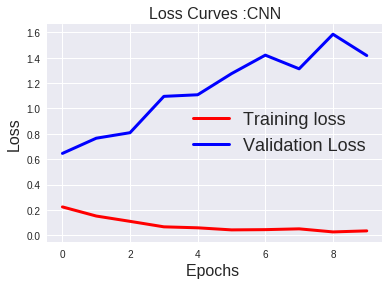

In [63]:
import matplotlib.pyplot as plt
%matplotlib inline

fig1 = plt.figure()
plt.plot(model1_hist.history['loss'],'r',linewidth=3.0)
plt.plot(model1_hist.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves :CNN',fontsize=16)
fig1.savefig('loss_cnn.png')
plt.show()



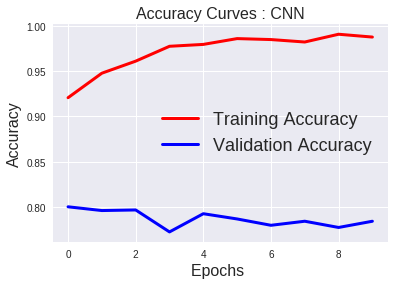

In [64]:
fig2=plt.figure()
plt.plot(model1_hist.history['acc'],'r',linewidth=3.0)
plt.plot(model1_hist.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves : CNN',fontsize=16)
fig2.savefig('accuracy_cnn.png')
plt.show()

In [0]:
predict = model1.predict(ts_data)

In [0]:
test_classes = predict.argmax(axis=-1)

In [51]:
test_classes

array([5, 1, 1, ..., 0, 5, 4])

In [0]:
categories = []

In [0]:
for x in range(0, test_classes.size):
  a = test_classes[x]
  categories.append(labels_index[a])

In [54]:
categories

['PRESCRIPTION',
 'ASK_A_DOCTOR',
 'ASK_A_DOCTOR',
 'ASK_A_DOCTOR',
 'MISCELLANEOUS',
 'PRESCRIPTION',
 'PRESCRIPTION',
 'LAB',
 'APPOINTMENTS',
 'LAB',
 'APPOINTMENTS',
 'ASK_A_DOCTOR',
 'APPOINTMENTS',
 'MISCELLANEOUS',
 'APPOINTMENTS',
 'ASK_A_DOCTOR',
 'PRESCRIPTION',
 'ASK_A_DOCTOR',
 'MISCELLANEOUS',
 'MISCELLANEOUS',
 'PRESCRIPTION',
 'ASK_A_DOCTOR',
 'LAB',
 'APPOINTMENTS',
 'PRESCRIPTION',
 'ASK_A_DOCTOR',
 'MISCELLANEOUS',
 'APPOINTMENTS',
 'ASK_A_DOCTOR',
 'APPOINTMENTS',
 'MISCELLANEOUS',
 'ASK_A_DOCTOR',
 'ASK_A_DOCTOR',
 'PRESCRIPTION',
 'MISCELLANEOUS',
 'ASK_A_DOCTOR',
 'PRESCRIPTION',
 'PRESCRIPTION',
 'APPOINTMENTS',
 'PRESCRIPTION',
 'PRESCRIPTION',
 'APPOINTMENTS',
 'ASK_A_DOCTOR',
 'APPOINTMENTS',
 'APPOINTMENTS',
 'PRESCRIPTION',
 'LAB',
 'APPOINTMENTS',
 'PRESCRIPTION',
 'LAB',
 'PRESCRIPTION',
 'MISCELLANEOUS',
 'ASK_A_DOCTOR',
 'APPOINTMENTS',
 'APPOINTMENTS',
 'APPOINTMENTS',
 'APPOINTMENTS',
 'MISCELLANEOUS',
 'LAB',
 'APPOINTMENTS',
 'PRESCRIPTION',
 'MISCEL

In [0]:
test_id = df_test['ID']

In [0]:
submission = pd.DataFrame({'ID':test_id, 'categories':categories})

In [58]:
submission.head()

,ID,categories
0,1,PRESCRIPTION
1,4,ASK_A_DOCTOR
2,7,ASK_A_DOCTOR
3,13,ASK_A_DOCTOR
4,18,MISCELLANEOUS


In [0]:
submission.to_csv('simple_cnn2.csv', index= False)

In [0]:
from google.colab import files
files.download('simple_cnn2.csv')

**CNN model - opt :rmsprop**

In [0]:
from keras.layers import Flatten
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
l_cov1= Conv1D(128, 5, activation='relu')(embedded_sequences)
l_pool1 = MaxPooling1D(5)(l_cov1)
l_cov2 = Conv1D(128, 5, activation='relu')(l_pool1)
l_pool2 = MaxPooling1D(5)(l_cov2)
l_cov3 = Conv1D(128, 5, activation='relu')(l_pool2)
l_pool3 = MaxPooling1D(35)(l_cov3)  # global max pooling
l_flat = Flatten()(l_pool3)
l_dense = Dense(128, activation='relu')(l_flat)
preds = Dense(len(labels_index), activation='softmax')(l_dense)

model2 = Model(sequence_input, preds)
model2.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

print("Simplified convolutional neural network")
model2.summary()
cp=ModelCheckpoint('model_cnn2.hdf5',monitor='val_acc',verbose=1,save_best_only=True)

Simplified convolutional neural network
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1000, 100)         3477000   
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 996, 128)          64128     
_________________________________________________________________
max_pooling1d_19 (MaxPooling (None, 199, 128)          0         
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 195, 128)          82048     
_________________________________________________________________
max_pooling1d_20 (MaxPooling (None, 39, 128)           0         
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 

In [0]:
model2_hist = model1.fit(x_train, y_train,
              batch_size=128,
              epochs=nb_epochs,
              validation_data=(x_val, y_val),callbacks=[cp])

Train on 36660 samples, validate on 9165 samples
Epoch 1/50
36660/36660 [==============================] - 26s 697us/step - loss: 0.0103 - acc: 0.9966 - val_loss: 2.2361 - val_acc: 0.7710

Epoch 00001: val_acc improved from -inf to 0.77098, saving model to model_cnn2.hdf5
Epoch 2/50
36660/36660 [==============================] - 25s 687us/step - loss: 0.0110 - acc: 0.9962 - val_loss: 2.2645 - val_acc: 0.7718

Epoch 00002: val_acc improved from 0.77098 to 0.77185, saving model to model_cnn2.hdf5
Epoch 3/50
36660/36660 [==============================] - 25s 684us/step - loss: 0.0138 - acc: 0.9955 - val_loss: 2.2160 - val_acc: 0.7710

Epoch 00003: val_acc did not improve from 0.77185
Epoch 4/50
36660/36660 [==============================] - 25s 686us/step - loss: 0.0147 - acc: 0.9949 - val_loss: 2.0785 - val_acc: 0.7661

Epoch 00004: val_acc did not improve from 0.77185
Epoch 5/50
36660/36660 [==============================] - 25s 686us/step - loss: 0.0128 - acc: 0.9956 - val_loss: 2.1160

**1D-CNN - Random Embeddings**

In [0]:
# train a 1D convnet with global maxpooling
print('Build model...')

from keras.models import Sequential
model3 = Sequential()
model3.add(Embedding(num_words,
                    EMBEDDING_DIM,
                    input_length=MAX_SEQUENCE_LENGTH))
model3.add(Conv1D(128, 5, activation='relu'))
model3.add(MaxPooling1D(5))
model3.add(Conv1D(128, 5, activation='relu'))
model3.add(MaxPooling1D(5))
model3.add(Conv1D(128, 5, activation='relu'))
model3.add(GlobalMaxPooling1D())
model3.add(Dense(128, activation='relu'))
model3.add(Dense(len(labels_index), activation='softmax'))

from keras.optimizers import Adam
adam = Adam(lr=0.001)
model3.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['acc'])

model3.summary()
cp=ModelCheckpoint('model_cnn3.hdf5',monitor='val_acc',verbose=1,save_best_only=True)

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 1000, 100)         3477000   
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 996, 128)          64128     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 199, 128)          0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 195, 128)          82048     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 39, 128)           0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 35, 128)           82048     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 128)               0     

In [0]:
model3_hist =  model3.fit(x_train, y_train,
              batch_size=128,
              epochs=nb_epochs,
              validation_data=(x_val, y_val), callbacks=[cp])

Train on 36660 samples, validate on 9165 samples
Epoch 1/50
36660/36660 [==============================] - 27s 746us/step - loss: 0.8401 - acc: 0.6806 - val_loss: 0.5751 - val_acc: 0.7956

Epoch 00001: val_acc improved from -inf to 0.79564, saving model to model_cnn3.hdf5
Epoch 2/50
36660/36660 [==============================] - 25s 680us/step - loss: 0.4871 - acc: 0.8221 - val_loss: 0.5144 - val_acc: 0.8110

Epoch 00002: val_acc improved from 0.79564 to 0.81102, saving model to model_cnn3.hdf5
Epoch 3/50
36660/36660 [==============================] - 25s 678us/step - loss: 0.3900 - acc: 0.8607 - val_loss: 0.5340 - val_acc: 0.8115

Epoch 00003: val_acc improved from 0.81102 to 0.81146, saving model to model_cnn3.hdf5
Epoch 4/50
36660/36660 [==============================] - 25s 676us/step - loss: 0.3006 - acc: 0.8936 - val_loss: 0.5970 - val_acc: 0.7959

Epoch 00004: val_acc did not improve from 0.81146
Epoch 5/50
36660/36660 [==============================] - 25s 673us/step - loss: 0.

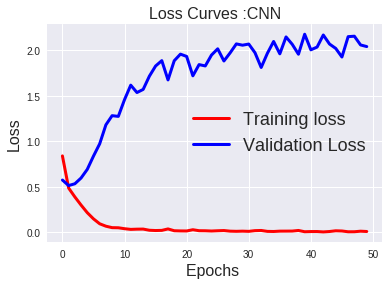

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

fig3 = plt.figure()
plt.plot(model3_hist.history['loss'],'r',linewidth=3.0)
plt.plot(model3_hist.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves :CNN',fontsize=16)
fig3.savefig('loss_cnn.png')
plt.show()

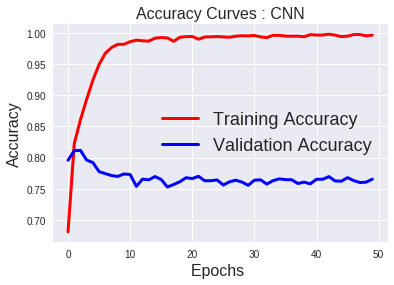

In [0]:
fig4=plt.figure()
plt.plot(model3_hist.history['acc'],'r',linewidth=3.0)
plt.plot(model3_hist.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves : CNN',fontsize=16)
fig4.savefig('accuracy_cnn.png')
plt.show()

**LSTM - GLOVE Vectors**

In [36]:
from keras.layers import LSTM, Dropout
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
z = Dropout(0.2)(embedded_sequences)
z = LSTM(128)(z)
z = Dropout(0.4)(z)
preds_lstm = Dense(6, activation='softmax')(z)


from keras.optimizers import Adam
adam = Adam(lr=0.001)
model_lstm = Model(sequence_input, preds_lstm)
model_lstm.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['acc'])

model_lstm.summary()
cp=ModelCheckpoint('model_lstm.hdf5',monitor='val_acc',verbose=1,save_best_only=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1000, 100)         3477000   
_________________________________________________________________
dropout_3 (Dropout)          (None, 1000, 100)         0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 774       
Total params: 3,595,022
Trainable params: 3,595,022
Non-trainable params: 0
_________________________________________________________________


In [38]:
model_lstm_hist = model_lstm.fit(x_train, y_train,
                  batch_size=128,
                  epochs=10,
                  validation_data=(x_val, y_val), callbacks=[cp])

Train on 36660 samples, validate on 9165 samples
Epoch 1/10
36660/36660 [==============================] - 901s 25ms/step - loss: 1.0545 - acc: 0.6001 - val_loss: 0.8074 - val_acc: 0.7145

Epoch 00001: val_acc improved from -inf to 0.71446, saving model to model_lstm.hdf5
Epoch 2/10
36660/36660 [==============================] - 928s 25ms/step - loss: 0.8300 - acc: 0.6976 - val_loss: 0.6655 - val_acc: 0.7645

Epoch 00002: val_acc improved from 0.71446 to 0.76454, saving model to model_lstm.hdf5
Epoch 3/10
36660/36660 [==============================] - 939s 26ms/step - loss: 0.6246 - acc: 0.7784 - val_loss: 0.5859 - val_acc: 0.7919

Epoch 00003: val_acc improved from 0.76454 to 0.79193, saving model to model_lstm.hdf5
Epoch 4/10
36660/36660 [==============================] - 946s 26ms/step - loss: 0.5549 - acc: 0.8007 - val_loss: 0.5489 - val_acc: 0.8038

Epoch 00004: val_acc improved from 0.79193 to 0.80382, saving model to model_lstm.hdf5
Epoch 5/10
36660/36660 [======================

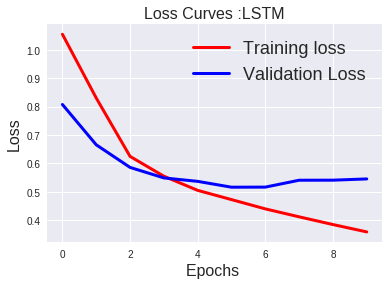

In [56]:
import matplotlib.pyplot as plt
%matplotlib inline

fig5 = plt.figure()
plt.plot(model_lstm_hist.history['loss'],'r',linewidth=3.0)
plt.plot(model_lstm_hist.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves :LSTM',fontsize=16)
fig5.savefig('loss_lstm.png')
plt.show()

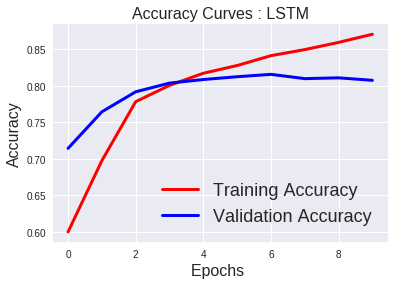

In [57]:
fig6=plt.figure()
plt.plot(model_lstm_hist.history['acc'],'r',linewidth=3.0)
plt.plot(model_lstm_hist.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves : LSTM',fontsize=16)
fig6.savefig('accuracy_lstm.png')
plt.show()

In [0]:
predict_ls = model_lstm.predict(ts_data)

In [0]:
test_classes_ls = predict_ls.argmax(axis=-1)

In [0]:
p = []
for x in range(0, test_classes_ls.size):
  a = test_classes_ls[x]
  p.append(labels_index[a])

In [0]:
submission2 = pd.DataFrame({'ID':test_id, 'categories':p})

In [0]:
submission2.to_csv('lstm.csv', index= False)

In [0]:
from google.colab import files
files.download('lstm.csv')

In [58]:
!ls

accuracy_cnn.png   loss_cnn.png   model_lstm.hdf5  train.csv   wget-log.2
accuracy_lstm.png  loss_lstm.png  sample_data	   wget-log
glove.6B.100d.txt  lstm.csv	  test.csv	   wget-log.1


In [0]:
from google.colab import files
files.download('loss_lstm.png')